In [2]:
import torch
import numpy as np
import json
from transformers import AutoTokenizer
import networkx as nx
import matplotlib.pyplot as plt
import hierarchical as hrc
from mpl_toolkits.mplot3d import Axes3D
from mpl_toolkits.mplot3d.art3d import Poly3DCollection

device = "cpu"
MODEL_NAME = "google/gemma-2b"
g, _, _ = hrc.get_g(MODEL_NAME, device)
vocab_dict, vocab_list = hrc.get_vocab(MODEL_NAME)
vocab_set = set(vocab_dict.keys())

`config.hidden_act` is ignored, you should use `config.hidden_activation` instead.
Gemma's activation function will be set to `gelu_pytorch_tanh`. Please, use
`config.hidden_activation` if you want to override this behaviour.
See https://github.com/huggingface/transformers/pull/29402 for more details.
Loading checkpoint shards: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:04<00:00,  2.03s/it]


In [18]:
import inflect
p = inflect.engine()

def make_token_set(word_list, pluralize=False, capitalize=True):
    result = set()

    for w in word_list:
        if capitalize: w = w.lower()
        candidates = ["▁" + w, "▁" + w.capitalize()] if capitalize else ["▁" + w]
        if pluralize:
            plural = p.plural(w)
            candidates += [plural, plural.capitalize()]
        for token in vocab_set.intersection(candidates):
            result.add(token)

    return result

In [19]:
g.shape

torch.Size([256000, 2048])

In [20]:
def find_nearest_tokens(point, k=10):
    query_vector = point.unsqueeze(0)  # (1, d)
    distances = torch.norm(g - query_vector, dim=1)  # (n, d)
    distances, indices = torch.topk(distances, k=k, largest=False)
    return [(distances[i], vocab_list[indices[i]]) for i in range(k)]

In [36]:
def plot3(name_to_tokens, union_name):
    fig = plt.figure(figsize=(20, 8))
    ax = fig.add_subplot(121, projection='3d')
    
    union_tokens = set().union(*name_to_tokens.values())
    
    dirs = dict(
        union=hrc.estimate_cat_dir(union_tokens, g, vocab_dict),
        **{k: hrc.estimate_cat_dir(tokens, g, vocab_dict) for k, tokens in name_to_tokens.items()}
    )

    k1, k2, k3 = name_to_tokens.keys()
    toks1, toks2, toks3 = name_to_tokens.values()
    dir1, dir2, dir3 = [dirs[k]["lda"] for k in name_to_tokens.keys()]
    higher_dir = dirs['union']["lda"]
    
    xaxis = dir1 / dir1.norm()
    yaxis = dir2 - (dir2 @ xaxis) * xaxis
    yaxis = yaxis / yaxis.norm()
    zaxis = dir3 - (dir3 @ xaxis) * xaxis - (dir3 @ yaxis) * yaxis
    zaxis = zaxis / zaxis.norm()
    
    axes = torch.stack([xaxis, yaxis, zaxis], dim=1)
    
    ind1, ind2, ind3 = [hrc.category_to_indices(toks, vocab_dict) for toks in name_to_tokens.values()]
    
    g1, g2, g3 = g[ind1], g[ind2], g[ind3]
    
    proj1 = (g1 @ axes).cpu().numpy()
    proj2 = (g2 @ axes).cpu().numpy()
    proj3 = (g3 @ axes).cpu().numpy()
    proj = (g @ axes).cpu().numpy()
    
    P1 = (dir1 @ axes).cpu().numpy()
    P2 = (dir2 @ axes).cpu().numpy()
    P3 = (dir3 @ axes).cpu().numpy()
    P4 = (higher_dir @ axes).cpu().numpy()
    
    ax.scatter(P1[0], P1[1], P1[2], color='r', s=100)
    ax.scatter(P2[0], P2[1], P2[2], color='g', s=100)
    ax.scatter(P3[0], P3[1], P3[2], color='b', s=100)
    
    verts = [list(zip([P1[0], P2[0], P3[0]], [P1[1], P2[1], P3[1]], [P1[2], P2[2], P3[2]]))]
    triangle = Poly3DCollection(verts, alpha=.2, linewidths=1, linestyle =  "--", edgecolors='k')
    triangle.set_facecolor('yellow')
    ax.add_collection3d(triangle)
    
    ax.quiver(0, 0, 0, P1[0], P1[1], P1[2], color='r', arrow_length_ratio=0.01)
    ax.quiver(0, 0, 0, P2[0], P2[1], P2[2], color='g', arrow_length_ratio=0.01)
    ax.quiver(0, 0, 0, P3[0], P3[1], P3[2], color='b', arrow_length_ratio=0.01)
    ax.quiver(0, 0, 0, P4[0], P4[1], P4[2], color='k', arrow_length_ratio=0.1, linewidth=2)
    
    
    scatter1 = ax.scatter(proj1[:,0], proj1[:,1], proj1[:,2], c='r', label=k1)
    scatter2 = ax.scatter(proj2[:,0], proj2[:,1], proj2[:,2], c='g', label=k2)
    scatter3 = ax.scatter(proj3[:,0], proj3[:,1], proj3[:,2], c='b', label=k3)
    scatter = ax.scatter(proj[:,0], proj[:,1], proj[:,2], c='gray', s= 0.05, alpha = 0.03)
    
    scale = 1.2
    ax.text(P1[0]*scale + 2, P1[1]* scale, P1[2]*scale, k1, bbox=dict(facecolor='r', alpha=0.2))
    ax.text(P2[0]*scale+0.5, P2[1]* scale+0.5, P2[2]*scale, k2, bbox=dict(facecolor='g', alpha=0.2))
    ax.text(P3[0]*scale, P3[1]* scale, P3[2]*scale, k3, bbox=dict(facecolor='b', alpha=0.2))
    ax.text(P4[0]-0.6, P4[1]-0.6, P4[2], union_name, bbox=dict(facecolor='k', alpha=0.2))
    
    normal_vector = np.cross(P2 - P1, P3 - P1)
    normal_vector = normal_vector / np.linalg.norm(normal_vector)
    normal_mag = P1 @ normal_vector
    normal_vector = normal_vector * normal_mag
    
    P1_normal = P1 - normal_vector
    P2_normal = P2 - normal_vector
    P3_normal = P3 - normal_vector
    
    ax.quiver(normal_vector[0], normal_vector[1], normal_vector[2], P1_normal[0], P1_normal[1], P1_normal[2],
              color='r', linestyle =  "--", arrow_length_ratio=0.01)
    ax.quiver(normal_vector[0], normal_vector[1], normal_vector[2], P2_normal[0], P2_normal[1], P2_normal[2],
              color='g', linestyle =  "--", arrow_length_ratio=0.01)
    ax.quiver(normal_vector[0], normal_vector[1], normal_vector[2], P3_normal[0], P3_normal[1], P3_normal[2],
              color='b', linestyle =  "--", arrow_length_ratio=0.01)
    
    ax.quiver(0, 0, 0, normal_vector[0], normal_vector[1], normal_vector[2], color='purple',
              linestyle =  "--", arrow_length_ratio=0.01)
    
    
    ax.set_xlim(0, 30)
    ax.set_ylim(0, 30)
    ax.set_zlim(0, 25)
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Z')
    
    ax.view_init(elev=20, azim=85)

In [164]:
def plot3_with_extras(name_to_tokens, extra_points):
    fig = plt.figure(figsize=(20, 8))
    ax = fig.add_subplot(121, projection='3d')
    
    dirs = {k: hrc.estimate_cat_dir(tokens, g, vocab_dict) for k, tokens in name_to_tokens.items()}

    k1, k2, k3 = name_to_tokens.keys()
    toks1, toks2, toks3 = name_to_tokens.values()
    dir1, dir2, dir3 = [dirs[k]["lda"] for k in name_to_tokens.keys()]
    
    xaxis = dir1 / dir1.norm()
    yaxis = dir2 - (dir2 @ xaxis) * xaxis
    yaxis = yaxis / yaxis.norm()
    zaxis = dir3 - (dir3 @ xaxis) * xaxis - (dir3 @ yaxis) * yaxis
    zaxis = zaxis / zaxis.norm()
    
    axes = torch.stack([xaxis, yaxis, zaxis], dim=1)
    
    ind1, ind2, ind3 = [hrc.category_to_indices(toks, vocab_dict) for toks in name_to_tokens.values()]
    
    g1, g2, g3 = g[ind1], g[ind2], g[ind3]
    
    proj1 = (g1 @ axes).cpu().numpy()
    proj2 = (g2 @ axes).cpu().numpy()
    proj3 = (g3 @ axes).cpu().numpy()
    proj = (g @ axes).cpu().numpy()
    
    P1 = (dir1 @ axes).cpu().numpy()
    P2 = (dir2 @ axes).cpu().numpy()
    P3 = (dir3 @ axes).cpu().numpy()
    
    ax.scatter(P1[0], P1[1], P1[2], color='r', s=100)
    ax.scatter(P2[0], P2[1], P2[2], color='g', s=100)
    ax.scatter(P3[0], P3[1], P3[2], color='b', s=100)
    
    verts = [list(zip([P1[0], P2[0], P3[0]], [P1[1], P2[1], P3[1]], [P1[2], P2[2], P3[2]]))]
    triangle = Poly3DCollection(verts, alpha=.2, linewidths=1, linestyle =  "--", edgecolors='k')
    triangle.set_facecolor('yellow')
    ax.add_collection3d(triangle)
    
    ax.quiver(0, 0, 0, P1[0], P1[1], P1[2], color='r', arrow_length_ratio=0.01)
    ax.quiver(0, 0, 0, P2[0], P2[1], P2[2], color='g', arrow_length_ratio=0.01)
    ax.quiver(0, 0, 0, P3[0], P3[1], P3[2], color='b', arrow_length_ratio=0.01)
    
    scatter1 = ax.scatter(proj1[:,0], proj1[:,1], proj1[:,2], c='r', label=k1)
    scatter2 = ax.scatter(proj2[:,0], proj2[:,1], proj2[:,2], c='g', label=k2)
    scatter3 = ax.scatter(proj3[:,0], proj3[:,1], proj3[:,2], c='b', label=k3)
    for name, point in extra_points.items():
        proj_point = point @ axes
        print(f'{proj_point=}')
        ax.scatter(point[0], point[1], point[2], c='c', label=name)
    scatter = ax.scatter(proj[:,0], proj[:,1], proj[:,2], c='gray', s= 0.05, alpha = 0.03)
    
    scale = 1.2
    ax.text(P1[0]*scale + 2, P1[1]* scale, P1[2]*scale, k1, bbox=dict(facecolor='r', alpha=0.2))
    ax.text(P2[0]*scale+0.5, P2[1]* scale+0.5, P2[2]*scale, k2, bbox=dict(facecolor='g', alpha=0.2))
    ax.text(P3[0]*scale, P3[1]* scale, P3[2]*scale, k3, bbox=dict(facecolor='b', alpha=0.2))
    
    normal_vector = np.cross(P2 - P1, P3 - P1)
    normal_vector = normal_vector / np.linalg.norm(normal_vector)
    normal_mag = P1 @ normal_vector
    normal_vector = normal_vector * normal_mag
    
    P1_normal = P1 - normal_vector
    P2_normal = P2 - normal_vector
    P3_normal = P3 - normal_vector
    
    ax.quiver(normal_vector[0], normal_vector[1], normal_vector[2], P1_normal[0], P1_normal[1], P1_normal[2],
              color='r', linestyle =  "--", arrow_length_ratio=0.01)
    ax.quiver(normal_vector[0], normal_vector[1], normal_vector[2], P2_normal[0], P2_normal[1], P2_normal[2],
              color='g', linestyle =  "--", arrow_length_ratio=0.01)
    ax.quiver(normal_vector[0], normal_vector[1], normal_vector[2], P3_normal[0], P3_normal[1], P3_normal[2],
              color='b', linestyle =  "--", arrow_length_ratio=0.01)
    
    ax.quiver(0, 0, 0, normal_vector[0], normal_vector[1], normal_vector[2], color='purple',
              linestyle =  "--", arrow_length_ratio=0.01)
    
    ax.set_xlim(0, 30)
    ax.set_ylim(0, 30)
    ax.set_zlim(0, 25)
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Z')
    
    ax.view_init(elev=20, azim=85)

In [138]:
def plot4(name_to_tokens, union_name):
    fig = plt.figure(figsize=(20, 8))
    ax = fig.add_subplot(122, projection='3d')

    dirs = dict(
        **{k: hrc.estimate_cat_dir(tokens, g, vocab_dict) for k, tokens in name_to_tokens.items()}
    )

    k1, k2, k3, k4 = name_to_tokens.keys()
    toks1, toks2, toks3, toks4 = name_to_tokens.values()
    dir1, dir2, dir3, dir4 = [dirs[k]["lda"] for k in name_to_tokens.keys()]
    
    xaxis = (dir2 - dir1) / (dir2-dir1).norm()
    yaxis = dir3 - dir1 - (dir3-dir1) @ xaxis * xaxis
    yaxis = yaxis / yaxis.norm()
    zaxis = (dir4 - dir1) - (dir4 - dir1) @ xaxis * xaxis - (dir4 - dir1) @ yaxis * yaxis
    zaxis = zaxis / zaxis.norm()
    
    axes = torch.stack([xaxis, yaxis, zaxis], dim=1)
    
    ind1 = hrc.category_to_indices(toks1, vocab_dict)
    ind2 = hrc.category_to_indices(toks2, vocab_dict)
    ind3 = hrc.category_to_indices(toks3, vocab_dict)
    ind4 = hrc.category_to_indices(toks4, vocab_dict)
    
    g1 = g[ind1]
    g2 = g[ind2]
    g3 = g[ind3]
    g4 = g[ind4]
    
    proj1 = (g1 @ axes).cpu().numpy()
    proj2 = (g2 @ axes).cpu().numpy()
    proj3 = (g3 @ axes).cpu().numpy()
    proj4 = (g4 @ axes).cpu().numpy()
    proj = (g @ axes).cpu().numpy()
    
    P1 = (dir1 @ axes).cpu().numpy()
    P2 = (dir2 @ axes).cpu().numpy()
    P3 = (dir3 @ axes).cpu().numpy()
    P4 = (dir4 @ axes).cpu().numpy()
    
    ax.scatter(P1[0], P1[1], P1[2], color=k1, s=100)
    ax.scatter(P2[0], P2[1], P2[2], color=k2, s=100)
    ax.scatter(P3[0], P3[1], P3[2], color=k3, s=100)
    ax.scatter(P4[0], P4[1], P4[2], color=k4, s=100)
    
    verts1 = [list(zip([P1[0], P2[0], P3[0]], [P1[1], P2[1], P3[1]], [P1[2], P2[2], P3[2]]))]
    triangle1 = Poly3DCollection(verts1, alpha=.1, linewidths=1, linestyle =  "--", edgecolors='k')
    triangle1.set_facecolor('yellow')
    ax.add_collection3d(triangle1)
    
    verts2 = [list(zip([P1[0], P2[0], P4[0]], [P1[1], P2[1], P4[1]], [P1[2], P2[2], P4[2]]))]
    triangle2 = Poly3DCollection(verts2, alpha=.1, linewidths=1, linestyle =  "--", edgecolors='k')
    triangle2.set_facecolor('yellow')
    ax.add_collection3d(triangle2)
    
    verts3 = [list(zip([P1[0], P3[0], P4[0]], [P1[1], P3[1], P4[1]], [P1[2], P3[2], P4[2]]))]
    triangle3 = Poly3DCollection(verts3, alpha=.1, linewidths=1, linestyle =  "--", edgecolors='k')
    triangle3.set_facecolor('yellow')
    ax.add_collection3d(triangle3)
    
    verts4 = [list(zip([P2[0], P3[0], P4[0]], [P2[1], P3[1], P4[1]], [P2[2], P3[2], P4[2]]))]
    triangle4 = Poly3DCollection(verts4, alpha=.1, linewidths=1, linestyle =  "--", edgecolors='k')
    triangle4.set_facecolor('yellow')
    ax.add_collection3d(triangle4)
    
    
    ax.quiver(0, 0, 0, P1[0], P1[1], P1[2], color=k1, arrow_length_ratio=0.01)
    ax.quiver(0, 0, 0, P2[0], P2[1], P2[2], color=k2, arrow_length_ratio=0.01)
    ax.quiver(0, 0, 0, P3[0], P3[1], P3[2], color=k3, arrow_length_ratio=0.01)
    ax.quiver(0, 0, 0, P4[0], P4[1], P4[2], color=k4, arrow_length_ratio=0.01)
    
    
    scatter1 = ax.scatter(proj1[:,0], proj1[:,1], proj1[:,2], c=k1, label=k1)
    scatter2 = ax.scatter(proj2[:,0], proj2[:,1], proj2[:,2], c=k2, label=k2)
    scatter3 = ax.scatter(proj3[:,0], proj3[:,1], proj3[:,2], c=k3, label=k3)
    scatter4 = ax.scatter(proj4[:,0], proj4[:,1], proj4[:,2], c=k4, label=k4)
    scatter = ax.scatter(proj[:,0], proj[:,1], proj[:,2], c='gray', s= 0.05, alpha = 0.01)
    
    
    scale = 1.4
    scale2 = 1.2
    ax.text(P1[0]*scale-1, P1[1]* scale, P1[2]*scale, k1, bbox=dict(facecolor=k1, alpha=0.2))
    ax.text(P2[0]*scale+1, P2[1]* scale, P2[2]*scale, k2, bbox=dict(facecolor=k2, alpha=0.2))
    ax.text(P3[0]*scale-1, P3[1]* scale, P3[2]*scale, k3, bbox=dict(facecolor=k3, alpha=0.2))
    ax.text(P4[0]*scale2+2, P4[1]* scale2, P4[2]*scale2-1, k4, bbox=dict(facecolor=k4, alpha=0.2))
    
    ax.set_xlim(0, 25)
    ax.set_ylim(35, 70)
    ax.set_zlim(0, 15)
    
    ax.view_init(elev=20, azim=70)

## color & plant / vegetable intersection

In [110]:
plant_colors = dict(
    red=make_token_set(["apple", "strawberry", "cherry", "raspberry", "tomato", "pomegranate", "radish"], pluralize=True),
    orange=make_token_set(["orange", "carrot", "tangerine", "cantaloupe", "papaya", "pumpkin", "apricot"], pluralize=True),
    yellow=make_token_set(["banana", "pineapple", "lemon", "corn", "starfruit"], pluralize=True),
    green=make_token_set(["lettuce", "spinach", "kale", "broccoli", "cucumber", "pea", "kiwi", "asparagus", "avocado", "lime"], pluralize=True),
)

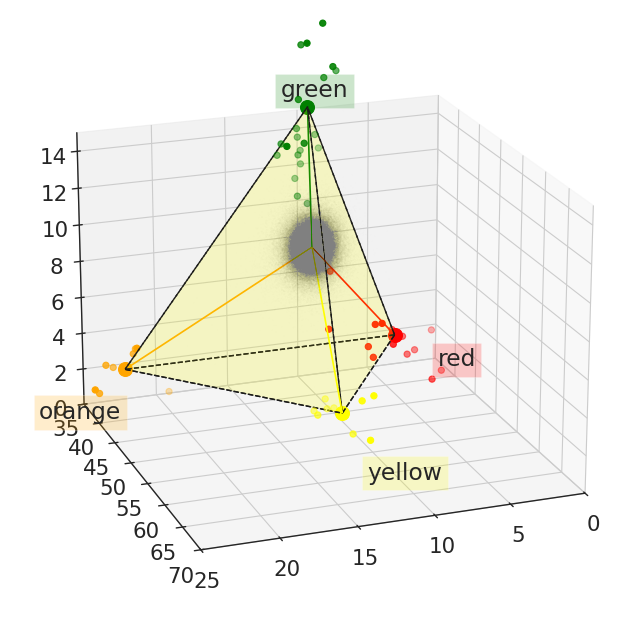

In [139]:
plot4(plant_colors, "red, orange, yellow, and green")

In [121]:
# ignore tomato / pumpkin
fruits_veggies = dict(
    fruit=make_token_set(["apple", "strawberry", "cherry", "raspberry", "pomegranate", "orange", "kiwi", "tangerine", "cantaloupe", "papaya", "apricot", "banana", "pineapple", "lemon", "starfruit", "avocado", "lime"
                         ], pluralize=True),
    veggie=make_token_set(["radish", "carrot", "corn", "lettuce", "spinach", "kale", "broccoli", "cucumber", "pea",  "asparagus",
                          ], pluralize=True),
)

In [118]:
with open("data/plants.json", "r", encoding="utf-8") as f:
    data = json.load(f)

plants_token = []
vocab_set = set(vocab_dict.keys())
lemmas = data["plant"]
for w in lemmas:
    plants_token.extend(hrc.noun_to_gemma_vocab_elements(w, vocab_set))

dirs_plants = hrc.estimate_cat_dir(plants_token, g, vocab_dict)

In [148]:
colors = iter(["b",  "orange", "r", "green", 
                       "skyblue", "pink",  "yellowgreen", "orange", "yellow",
                       "brown", "cyan", "olive", "purple", "lime"])

for label, indices in inds.items():
    color = next(colors)
    print(color)

b
orange
r


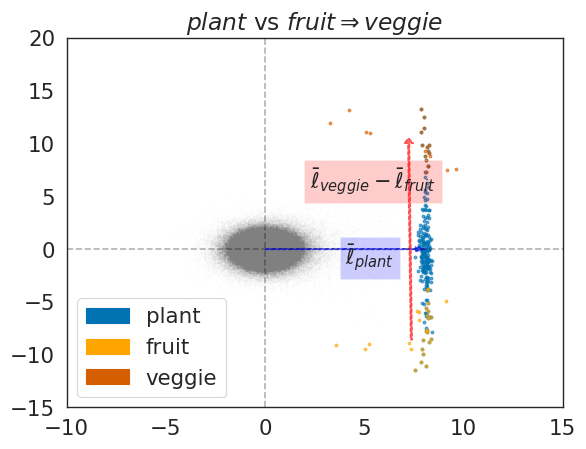

In [150]:
fig, ax = plt.subplots()

inds = {"plant": hrc.category_to_indices(plants_token, vocab_dict),
        "fruit": hrc.category_to_indices(fruits_veggies["fruit"], vocab_dict),
        "veggie": hrc.category_to_indices(fruits_veggies["veggie"], vocab_dict)}

dirs = {
    "plant": hrc.estimate_cat_dir(plants_token, g, vocab_dict),
    "fruit": hrc.estimate_cat_dir(fruits_veggies["fruit"], g, vocab_dict),
    "veggie": hrc.estimate_cat_dir(fruits_veggies["veggie"], g, vocab_dict),
}

higher = dirs["plant"]["lda"]
fruit_dir = dirs["fruit"]["lda"]
veggie_dir = dirs["veggie"]["lda"]

hrc.proj_2d_single_diff(higher, fruit_dir, veggie_dir,
                        g, vocab_list, ax,
                        normalize = True,
                        orthogonal = True,
                        added_inds=inds, k = 50, fontsize= 15,
                        draw_arrows= True,
                        arrow1_name=rf'$\bar{{\ell}}_{{plant}}$',
                        arrow2_name=rf'$\bar{{\ell}}_{{veggie}} - \bar{{\ell}}_{{fruit}}$',
                        alpha = 0.03,  s = 0.05,
                        target_alpha=0.6, target_s=4,
                        xlim = (-10,15), ylim = (-15,20),
                        right_topk = False,
                        left_topk = False,
                        top_topk = False,
                        bottom_topk = False,
                        xlabel = "", ylabel="",
                        title = rf'$plant$ vs $fruit \Rightarrow veggie$')

## fruit / vegetable intersection

## concept arithmetic

In [21]:
'▁Queen' in vocab_set, '▁queen' in vocab_set, 'Queen' in vocab_set, 'queen' in vocab_set

(True, True, True, True)

In [22]:
'▁Queens' in vocab_set, '▁queens' in vocab_set, 'Queens' in vocab_set, 'queens' in vocab_set

(True, True, True, True)

In [23]:
'▁QUEEN' in vocab_set, '▁QUEENS' in vocab_set, 'QUEEN' in vocab_set, 'QUEENS' in vocab_set

(True, False, True, False)

In [24]:
'▁King' in vocab_set, '▁king' in vocab_set, 'King' in vocab_set, 'king' in vocab_set

(True, True, True, True)

In [25]:
'▁KING' in vocab_set, '▁KINGS' in vocab_set, 'KING' in vocab_set, 'KINGS' in vocab_set

(True, True, True, False)

In [26]:
'▁Kings' in vocab_set, '▁kings' in vocab_set, 'Kings' in vocab_set, 'kings' in vocab_set

(True, True, True, True)

In [27]:
'▁Man' in vocab_set, '▁man' in vocab_set, 'Man' in vocab_set, 'man' in vocab_set

(True, True, True, True)

In [28]:
'▁Men' in vocab_set, '▁men' in vocab_set, 'Men' in vocab_set, 'men' in vocab_set

(True, True, True, True)

In [29]:
'▁Woman' in vocab_set, '▁woman' in vocab_set, 'Woman' in vocab_set, 'woman' in vocab_set

(True, True, True, True)

In [30]:
'▁Women' in vocab_set, '▁women' in vocab_set, 'Women' in vocab_set, 'women' in vocab_set

(True, True, True, True)

In [31]:
make_token_set(["king"], pluralize=True), make_token_set(["queen"], pluralize=True)

({'Kings', 'kings', '▁King', '▁king'},
 {'Queens', 'queens', '▁Queen', '▁queen'})

In [32]:
queen_tokens = {'▁Queen', '▁queen', 'Queen', 'queen', '▁Queens', '▁queens', 'Queens', 'queens', '▁QUEEN', 'QUEEN'}
king_tokens = {'▁King', '▁king', 'King', 'king', '▁Kings', '▁kings', 'Kings', 'kings', '▁KING', '▁KINGS', 'KING'}
man_tokens = {'▁Man', '▁man', 'Man', 'man', '▁Men', '▁men', 'Men', 'men'}
woman_tokens = {'▁Woman', '▁woman', 'Woman', 'woman', '▁Women', '▁women', 'Women', 'women'}
queen_dir = hrc.estimate_cat_dir(queen_tokens, g, vocab_dict)['lda']
king_dir = hrc.estimate_cat_dir(king_tokens, g, vocab_dict)['lda']
man_dir = hrc.estimate_cat_dir(man_tokens, g, vocab_dict)['lda']
woman_dir = hrc.estimate_cat_dir(woman_tokens, g, vocab_dict)['lda']

In [33]:
man_to_king_dir = king_dir - man_dir

man_to_woman_dir = woman_dir - man_dir

In [173]:
for tok in woman_tokens:
    print(f'{tok} (man -> king) ->')
    toks = find_nearest_tokens(g[vocab_dict[tok]] + man_to_king_dir, 3)
    for dist, tok in toks:
        print(f'  {tok} ({dist})')
    print()

▁Woman (man -> king) ->
  ▁Woman (31.150367736816406)
  Woman (37.92683792114258)
  ▁WOMAN (39.65561294555664)

Women (man -> king) ->
  Women (31.150367736816406)
  ▁Women (35.86464309692383)
  ▁women (37.9874382019043)

Woman (man -> king) ->
  Woman (31.150367736816406)
  ▁Woman (38.96299362182617)
  ▁WOMAN (42.89999008178711)

▁women (man -> king) ->
  ▁women (31.150367736816406)
  Women (37.259178161621094)
  ▁Women (38.239986419677734)

▁woman (man -> king) ->
  ▁woman (31.150367736816406)
  ▁Woman (40.89581298828125)
  ▁women (41.437374114990234)

woman (man -> king) ->
  woman (31.150367736816406)
  ▁woman (42.86234664916992)
  women (44.41108322143555)

▁Women (man -> king) ->
  ▁Women (31.150367736816406)
  Women (33.97146987915039)
  ▁WOMEN (36.89590835571289)

women (man -> king) ->
  women (31.150367736816406)
  ▁women (39.34971618652344)
  Women (39.90473556518555)



In [35]:
for tok in king_tokens:
    print(f'{tok} (man -> woman) ->')
    toks = find_nearest_tokens(g[vocab_dict[tok]] + man_to_woman_dir, 3)
    for dist, tok in toks:
        print(f'  {tok} ({dist})')
    print()

King (man -> woman) ->
  King (33.0550537109375)
  ▁King (37.10598373413086)
  ▁KING (42.13126754760742)

▁KING (man -> woman) ->
  ▁KING (33.0550537109375)
  ▁King (39.770347595214844)
  King (40.04966354370117)

kings (man -> woman) ->
  kings (33.0550537109375)
  Women (45.77772521972656)
  Kings (46.69305419921875)

▁king (man -> woman) ->
  ▁king (33.0550537109375)
  ▁King (40.4820442199707)
  King (40.61760711669922)

Kings (man -> woman) ->
  Kings (33.0550537109375)
  ▁Kings (40.8263053894043)
  Women (43.23965072631836)

▁King (man -> woman) ->
  ▁King (33.0550537109375)
  King (35.37310028076172)
  ▁KING (40.33796310424805)

king (man -> woman) ->
  king (33.0550537109375)
  KING (46.25809860229492)
  Women (47.19768142700195)

▁KINGS (man -> woman) ->
  ▁KINGS (33.0550537109375)
  ▁Kings (44.5788688659668)
  Women (44.90495300292969)

▁kings (man -> woman) ->
  ▁kings (33.0550537109375)
  ▁Kings (43.687530517578125)
  Women (43.78138732910156)

KING (man -> woman) ->
  KING 

## letters from different regions

### by shape

In [37]:
greek_upper    = ["Α",      "Β", "Γ", "Δ", "Ε",                                    "Η", "Θ", "Ι",      "Κ", "Λ",      "Μ", "Ν", "Ξ", "Ο", "Π", "Ρ", "Σ",           "Τ", "Υ", "Φ",      "Χ", "Ψ", "Ω", "Ζ"]
latin_upper    = ["A",      "B", "C", "D", "E", "F", "G",                          "H",      "I", "J", "K", "L",      "M", "N",      "O",      "P", "Q", "R", "S", "T", "U", "V", "W", "X", "Y",      "Z"]
cyrillic_upper = ["А", "Б", "В", "С", "Г", "Д", "Е", "Ж", "З", "И", "Й", "К", "Л", "Н", "О", "П", "Р",  "У", "М", "Ф", "Ц", "Ч", "Ш", "Щ", "Ъ", "Ы", "Ь", "Т", "Э", "Ю", "Я", "Х"]

greek_upper_shared    = ["Α", "Β", "Ε", "Η", "Μ", "Ρ", "Τ", "Χ"]
latin_upper_shared    = ["A", "B", "E", "H", "M", "P", "T", "X"]
cyrillic_upper_shared = ["А", "В", "Е", "Н", "М", "Р", "Т", "Х"]

In [168]:
ord('A'), ord('Z')

(65, 90)

In [38]:
([ord(c) for c in latin_upper_shared],
 [ord(c) for c in greek_upper_shared],
 [ord(c) for c in cyrillic_upper_shared],
)

([65, 66, 69, 72, 77, 80, 84, 88],
 [913, 914, 917, 919, 924, 929, 932, 935],
 [1040, 1042, 1045, 1053, 1052, 1056, 1058, 1061])

In [39]:
upper_letters = greek_upper + latin_upper + cyrillic_upper
lower_letters = [c.lower() for c in upper_letters]
all_letters = upper_letters + lower_letters

In [40]:
len(upper_letters), len(lower_letters), len(all_letters)

(82, 82, 164)

In [42]:
# len(upper_tokens), len(lower_tokens), len(upper_lower_tokens)

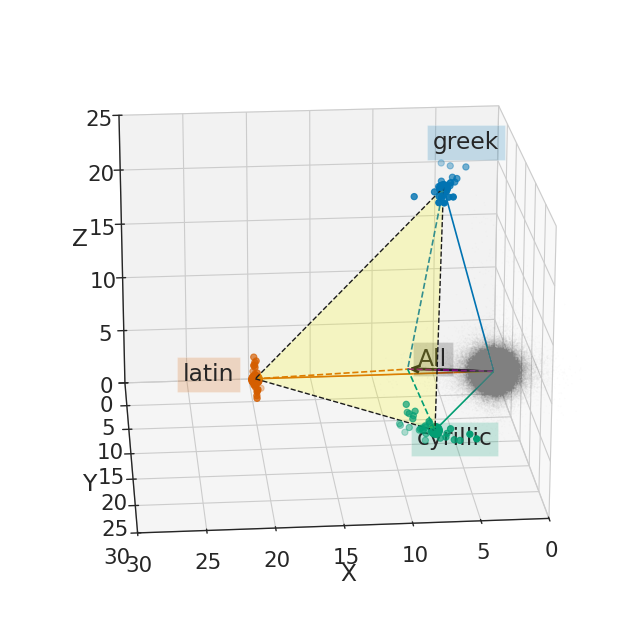

In [43]:
latin, cyrillic, greek = [make_token_set(toks, capitalize=False) for toks in [latin_upper, cyrillic_upper, greek_upper]]

plot3(dict(latin=latin, cyrillic=cyrillic, greek=greek), "All")

In [44]:
As, Bs, Es, Hs, Ms, Ps, Ts, Xs = list(zip(greek_upper_shared, latin_upper_shared, cyrillic_upper_shared))

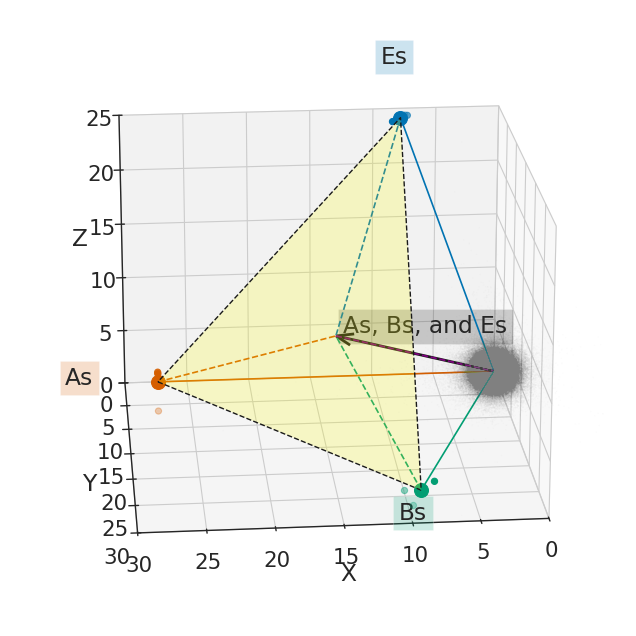

In [45]:
plot3(dict(As=As, Bs=Bs, Es=Es), "As, Bs, and Es")

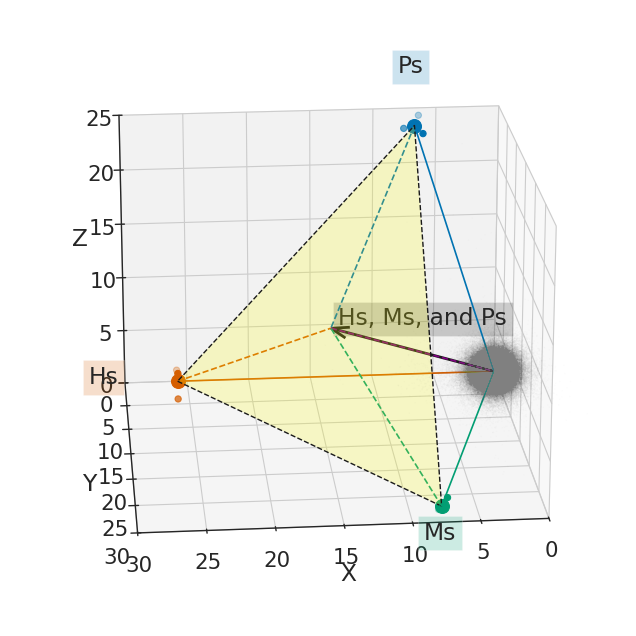

In [46]:
plot3(dict(Hs=Hs, Ms=Ms, Ps=Ps), "Hs, Ms, and Ps")

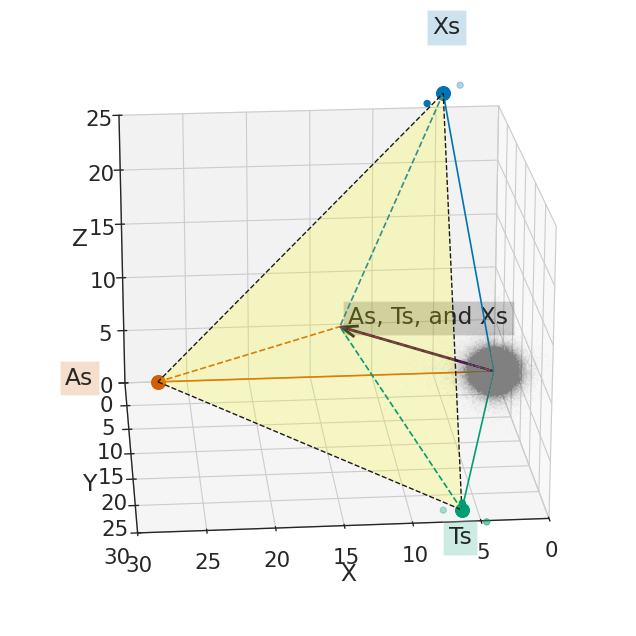

In [47]:
plot3(dict(As=As, Ts=Ts, Xs=Xs), "As, Ts, and Xs")

/var/folders/g3/z_s5yp7j3s9447pfnkyzg3sc0000gn/T/ipykernel_22128/3352089403.py:35: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


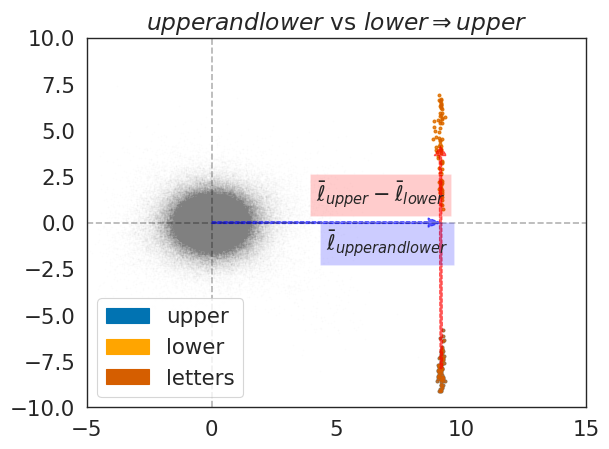

In [51]:
upper_tokens = make_token_set(upper_letters, capitalize=False)
lower_tokens = make_token_set(lower_letters, capitalize=False)
upper_lower_tokens = make_token_set(upper_letters + lower_letters, capitalize=False)

fig, ax = plt.subplots()

inds = {"upper": hrc.category_to_indices(upper_tokens, vocab_dict),
         "lower": hrc.category_to_indices(lower_tokens, vocab_dict),
         "letters": hrc.category_to_indices(upper_lower_tokens, vocab_dict)}

higher = hrc.estimate_cat_dir(upper_lower_tokens, g, vocab_dict)['lda']
subcat1 = hrc.estimate_cat_dir(upper_tokens, g, vocab_dict)['lda']
subcat2 = hrc.estimate_cat_dir(lower_tokens, g, vocab_dict)['lda']

hrc.proj_2d_single_diff(higher, subcat1, subcat2,
                        g, vocab_list, ax,
                        normalize = True,
                        orthogonal = True,
                        added_inds=inds, k = 50, fontsize= 15,
                        draw_arrows= True,
                        arrow1_name=rf'$\bar{{\ell}}_{{upper and lower}}$',
                        arrow2_name=rf'$\bar{{\ell}}_{{upper}} - \bar{{\ell}}_{{lower}}$',
                        alpha = 0.03,  s = 0.05,
                        target_alpha=0.6, target_s=4,
                        xlim = (-5,15), ylim = (-10,10),
                        right_topk = False,
                        left_topk = False,
                        top_topk = False,
                        bottom_topk = False,
                        xlabel = "", ylabel="",
                        title = rf'$upper and lower$ vs $lower \Rightarrow upper$')

fig.tight_layout()
fig.savefig(f"figures/upper_vs_lower.png", dpi=300, bbox_inches='tight')
fig.show()

Text(5, 5, 'cyrillic')

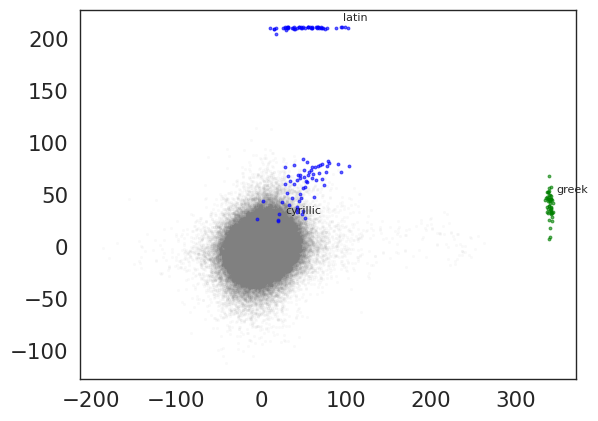

In [170]:
greek_tokens = make_token_set(greek_upper)
latin_tokens = make_token_set(latin_upper)
cyrillic_tokens = make_token_set(cyrillic_upper)

dirs = dict(
    greek=hrc.estimate_cat_dir(greek_tokens, g, vocab_dict),
    latin=hrc.estimate_cat_dir(latin_tokens, g, vocab_dict),
    cyrillic=hrc.estimate_cat_dir(cyrillic_tokens, g, vocab_dict),
)

fig, ax = plt.subplots()
proj1 = g @ dirs['greek']['lda']
proj2 = g @ dirs['latin']['lda']
ax.scatter(proj1.cpu().numpy(), proj2.cpu().numpy(), alpha=0.03, color="gray", s=2)

for i in hrc.category_to_indices(greek_tokens, vocab_dict):
    word = vocab_list[i]
    x, y = proj1[i].cpu().numpy(), proj2[i].cpu().numpy()
    ax.scatter(x, y, alpha=0.6, color="green", s=4)
ax.annotate('greek', (x, y), xytext=(5, 5), textcoords='offset points', fontsize=8)

for i in hrc.category_to_indices(latin_tokens, vocab_dict):
    word = vocab_list[i]
    x, y = proj1[i].cpu().numpy(), proj2[i].cpu().numpy()
    ax.scatter(x, y, alpha=0.6, color="blue", s=4)
ax.annotate('latin', (x, y), xytext=(5, 5), textcoords='offset points', fontsize=8)

for i in hrc.category_to_indices(cyrillic_tokens, vocab_dict):
    word = vocab_list[i]
    x, y = proj1[i].cpu().numpy(), proj2[i].cpu().numpy()
    ax.scatter(x, y, alpha=0.6, color="blue", s=4)
ax.annotate('cyrillic', (x, y), xytext=(5, 5), textcoords='offset points', fontsize=8)

In [154]:
ord("▁А".replace("▁", ""))

1040

In [171]:
latin_to_cyrillic = dirs['cyrillic']['lda'] - dirs['latin']['lda']
latin_to_greek    = dirs['greek']['lda']    - dirs['latin']['lda']

def tok_ord(tok):
    return ord(tok.replace("▁", ""))

extra_points = {}

for letter in latin_upper_shared:
    print(f'{letter} ({ord(letter)}) to Cyrillic:')
    c_pt = g[vocab_dict[letter]] + latin_to_cyrillic
    c_toks = find_nearest_tokens(c_pt, 3)
    extra_points[f'{letter} to Cyrillic'] = c_pt
    for dist, tok in c_toks:
        print(f'  {tok} ({tok_ord(tok)})')
        
    print(f'{letter} ({ord(letter)}) to Greek:')
    g_pt = g[vocab_dict[letter]] + latin_to_greek
    g_toks = find_nearest_tokens(g_pt, 3)
    extra_points[f'{letter} to Greek'] = g_pt
    for dist, tok in g_toks:
        print(f'  {tok} ({tok_ord(tok)})')
    print()

A (65) to Cyrillic:
  A (65)
  ▁A (65)
  ▁А (1040)
A (65) to Greek:
  A (65)
  ▁A (65)
  ▁А (1040)

B (66) to Cyrillic:
  B (66)
  ▁B (66)
  ▁Б (1041)
B (66) to Greek:
  B (66)
  ▁B (66)
  Ｂ (65314)

E (69) to Cyrillic:
  E (69)
  ▁E (69)
  ▁Е (1045)
E (69) to Greek:
  E (69)
  ▁E (69)
  ▁Е (1045)

H (72) to Cyrillic:
  H (72)
  ▁H (72)
  Ｈ (65320)
H (72) to Greek:
  H (72)
  ▁H (72)
  Ｈ (65320)

M (77) to Cyrillic:
  M (77)
  ▁M (77)
  ▁М (1052)
M (77) to Greek:
  M (77)
  ▁M (77)
  ▁М (1052)

P (80) to Cyrillic:
  P (80)
  ▁P (80)
  ▁П (1055)
P (80) to Greek:
  P (80)
  ▁P (80)
  ▁П (1055)

T (84) to Cyrillic:
  T (84)
  ▁T (84)
  ▁Т (1058)
T (84) to Greek:
  T (84)
  ▁T (84)
  ▁Т (1058)

X (88) to Cyrillic:
  X (88)
  ▁X (88)
  x (120)
X (88) to Greek:
  X (88)
  ▁X (88)
  Ｘ (65336)



proj_point=tensor([ 1.2108,  6.3840, -0.9028])
proj_point=tensor([ 1.2924,  1.8226, 15.3559])
proj_point=tensor([ 0.2801,  8.8370, -0.7123])
proj_point=tensor([ 0.3618,  4.2756, 15.5464])
proj_point=tensor([ 0.4152,  9.8673, -1.3497])
proj_point=tensor([ 0.4969,  5.3060, 14.9091])
proj_point=tensor([0.6773, 8.8673, 0.5831])
proj_point=tensor([ 0.7589,  4.3060, 16.8418])
proj_point=tensor([0.4934, 8.2167, 0.2003])
proj_point=tensor([ 0.5750,  3.6553, 16.4590])
proj_point=tensor([ 0.5480,  8.2660, -0.5254])
proj_point=tensor([ 0.6296,  3.7046, 15.7334])
proj_point=tensor([ 0.7502,  8.1395, -0.7293])
proj_point=tensor([ 0.8318,  3.5781, 15.5294])
proj_point=tensor([ 1.9407,  8.0355, -0.4538])
proj_point=tensor([ 2.0224,  3.4742, 15.8049])


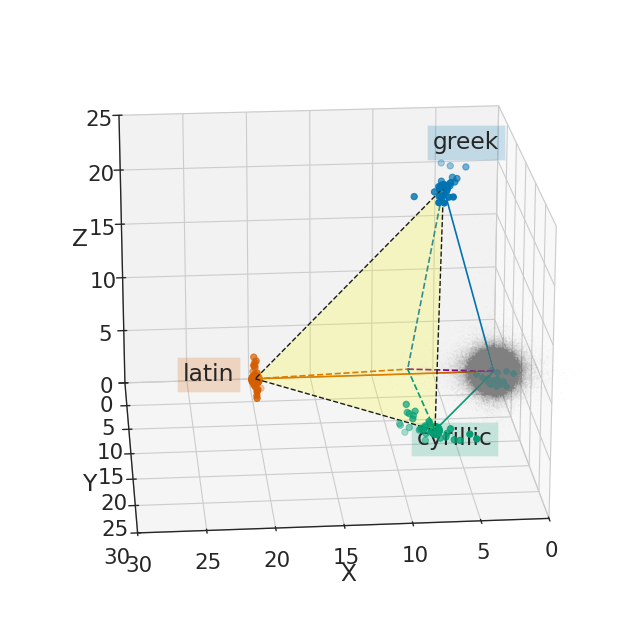

In [165]:
latin, cyrillic, greek = [make_token_set(toks, capitalize=False) for toks in [latin_upper, cyrillic_upper, greek_upper]]

plot3_with_extras(dict(latin=latin, cyrillic=cyrillic, greek=greek), extra_points)

### numbers

In [54]:
cjk_digits = set(["一", "二", "三", "四", "五", "六", "七", "八", "九", "十", "百", "千", "万"])

In [55]:
hardcoded = {
    '百': 100,
    '一百': 100,
    '二百': 200,
    '三百': 300,
    '五百': 500,
    '一千': 1000,
    '千': 1000,
    '三千': 3000, 
    '万': 10_000, 
    '万一': 10_001, 
    '百万': 1_000_000,
    '千万': 10_000_000
}

def cjk_to_number(s: str) -> int:
    if s in hardcoded:
        return hardcoded[s]
    result = 0
    while s:
        result *= 10
        result += ["一", "二", "三", "四", "五", "六", "七", "八", "九", "十"].index(s[0]) + 1
        s = s[1:]
    return result

In [56]:
cjk_numbers = sorted([k for k in vocab_dict.keys() if all(d in cjk_digits for d in k) and str(cjk_to_number(k))], key=cjk_to_number)
arabic_numerals = [str(cjk_to_number(s)) for s in cjk_numbers]

In [57]:
list(zip(cjk_numbers, arabic_numerals))

[('一', '1'),
 ('二', '2'),
 ('三', '3'),
 ('四', '4'),
 ('五', '5'),
 ('六', '6'),
 ('七', '7'),
 ('八', '8'),
 ('九', '9'),
 ('十', '10'),
 ('一一', '11'),
 ('一二', '12'),
 ('一八', '18'),
 ('一九', '19'),
 ('二十', '30'),
 ('三四', '34'),
 ('三十', '40'),
 ('四十', '50'),
 ('五三', '53'),
 ('五六', '56'),
 ('五十', '60'),
 ('六十', '70'),
 ('七八', '78'),
 ('七十', '80'),
 ('八十', '90'),
 ('一百', '100'),
 ('百', '100'),
 ('十一', '101'),
 ('十二', '102'),
 ('十三', '103'),
 ('十四', '104'),
 ('十五', '105'),
 ('十六', '106'),
 ('十七', '107'),
 ('十八', '108'),
 ('十九', '109'),
 ('二百', '200'),
 ('三百', '300'),
 ('二十四', '304'),
 ('五百', '500'),
 ('一千', '1000'),
 ('千', '1000'),
 ('三千', '3000'),
 ('万', '10000'),
 ('万一', '10001'),
 ('百万', '1000000'),
 ('千万', '10000000')]

In [58]:
cjk_number_tokens = make_token_set(cjk_numbers)
arabic_numeral_tokens = make_token_set(arabic_numerals)

In [59]:
len(arabic_numeral_tokens), len(cjk_number_tokens)

(0, 14)

In [60]:
set(arabic_numerals).intersection(vocab_set)

{'1', '2', '3', '4', '5', '6', '7', '8', '9'}

In [61]:
[k for k in vocab_dict.keys() if all(d in "0123456789" for d in k)]

['4', '3', '1', '6', '7', '9', '0', '5', '2', '8']

In [62]:
cjk_number_tokens = make_token_set(["一", "二", "三", "四", "五", "六", "七", "八", "九", "十"])
arabic_numeral_tokens = set([str(x) for x in range(10)])

In [63]:
cjk_number_tokens, arabic_numeral_tokens

({'▁一', '▁七', '▁三', '▁九', '▁二', '▁五', '▁八', '▁六', '▁十', '▁四'},
 {'0', '1', '2', '3', '4', '5', '6', '7', '8', '9'})

In [166]:
arabic_dir = hrc.estimate_cat_dir(arabic_numeral_tokens, g, vocab_dict)['lda']
cjk_dir    = hrc.estimate_cat_dir(cjk_number_tokens, g, vocab_dict)['lda']

spelled_number_tokens = make_token_set(["one", "two", "three", "four", "five", "six", "seven", "eight", "nine", "ten"])
spelled_number_dir = hrc.estimate_cat_dir(spelled_number_tokens, g, vocab_dict)['lda']

arabic_to_cjk = cjk_dir - arabic_dir
arabic_to_spelled = spelled_number_dir - arabic_dir

for i in range(10):
    cjk_loc = g[vocab_dict[str(i)]] + arabic_to_cjk
    print(f'{i} to Chinese:')
    toks = find_nearest_tokens(cjk_loc, 3)
    for dist, tok in toks:
        print(f'  {tok} ({dist})')

    spelled_loc = g[vocab_dict[str(i)]] + arabic_to_spelled
    print(f'{i} to Spelled-out:')
    toks = find_nearest_tokens(spelled_loc, 3)
    for dist, tok in toks:
        print(f'  {tok} ({dist})')
    print()

0 to Chinese:
   (31.47524642944336)
   (31.505502700805664)
  ஡ (31.510705947875977)
0 to Spelled-out:
  ０ (33.4927978515625)
  ⦊ (33.906803131103516)
   (33.93096923828125)

1 to Chinese:
  ▁一 (29.209413528442383)
  ⏡ (31.11988639831543)
   (31.155630111694336)
1 to Spelled-out:
  ⸄ (33.620243072509766)
  ▁ſuo (33.646976470947266)
   (33.67442321777344)

2 to Chinese:
  ▁۲ (30.88833999633789)
  ２ (31.432994842529297)
   (31.439632415771484)
2 to Spelled-out:
  ▁Two (29.852327346801758)
  ▁two (30.968053817749023)
  ▁два (30.96965980529785)

3 to Chinese:
  ▁三 (24.680652618408203)
  三 (28.264665603637695)
  ▁۳ (29.061429977416992)
3 to Spelled-out:
  ▁three (25.776763916015625)
  ▁Three (26.883649826049805)
  Three (27.575172424316406)

4 to Chinese:
  ▁四 (27.26593017578125)
  四 (28.639314651489258)
  ▁۴ (29.196598052978516)
4 to Spelled-out:
  ▁four (25.17339324951172)
  ▁Four (26.426578521728516)
  Four (27.922405242919922)

5 to Chinese:
  ▁五 (27.11167335510254)
  五 (28.06393

/var/folders/g3/z_s5yp7j3s9447pfnkyzg3sc0000gn/T/ipykernel_22128/492347477.py:33: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


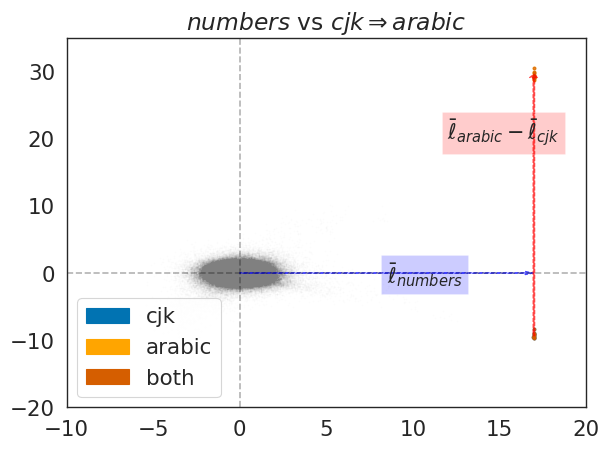

In [65]:
fig, ax = plt.subplots()

both_tokens = cjk_number_tokens | arabic_numeral_tokens

inds1 = {"cjk": hrc.category_to_indices(cjk_number_tokens, vocab_dict),
         "arabic": hrc.category_to_indices(arabic_numeral_tokens, vocab_dict),
         "both": hrc.category_to_indices(both_tokens, vocab_dict)}

higher = hrc.estimate_cat_dir(both_tokens, g, vocab_dict)['lda']
subcat1 = hrc.estimate_cat_dir(cjk_number_tokens, g, vocab_dict)['lda']
subcat2 = hrc.estimate_cat_dir(arabic_numeral_tokens, g, vocab_dict)['lda']

hrc.proj_2d_single_diff(higher, subcat1, subcat2,
                        g, vocab_list, ax,
                        normalize = True,
                        orthogonal = True,
                        added_inds=inds1, k = 50, fontsize= 15,
                        draw_arrows= True,
                        arrow1_name=rf'$\bar{{\ell}}_{{numbers}}$',
                        arrow2_name=rf'$\bar{{\ell}}_{{arabic}} - \bar{{\ell}}_{{cjk}}$',
                        alpha = 0.03,  s = 0.05,
                        target_alpha=0.6, target_s=4,
                        xlim = (-10,20), ylim = (-20,35),
                        right_topk = False,
                        left_topk = False,
                        top_topk = False,
                        bottom_topk = False,
                        xlabel = "", ylabel="",
                        title = rf'$numbers$ vs $cjk \Rightarrow arabic$')

fig.tight_layout()
fig.savefig(f"figures/cjk_vs_arabic.png", dpi=300, bbox_inches='tight')
fig.show()

In [66]:
cjk_dir = hrc.estimate_cat_dir(cjk_number_tokens, g, vocab_dict)["lda"]
arabic_dir = hrc.estimate_cat_dir(arabic_numeral_tokens, g, vocab_dict)["lda"]
both_dir = hrc.estimate_cat_dir(both_tokens, g, vocab_dict)["lda"]

dir1 = both_dir
dir1 = dir1 / dir1.norm()

dir2 = arabic_dir - cjk_dir
dir2 = dir2 - (dir2 @ dir1) * dir1
dir2 = dir2 / dir2.norm()

proj1 = g @ dir1
proj2 = g @ dir2

/var/folders/g3/z_s5yp7j3s9447pfnkyzg3sc0000gn/T/ipykernel_22128/3333291969.py:25: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


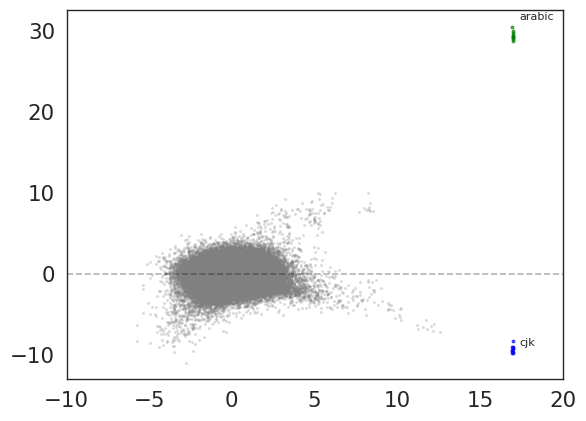

In [67]:
fig, ax = plt.subplots()

ax.scatter(proj1.cpu().numpy(), proj2.cpu().numpy(), alpha=0.2, color="gray", s=2)

xlim, ylim = (-10, 20), (-20,35)
ax.set_xlim(xlim)
ax.hlines(0, xmax=xlim[1], xmin=xlim[0],
          colors="black", alpha=0.3, linestyles="dashed")
# ax.set_ylim(ylim)
# ax.vlines(0, ymax=ylim[1], ymin=ylim[0],
#           colors="black", alpha=0.3, linestyles="dashed")

for i in hrc.category_to_indices(arabic_numeral_tokens, vocab_dict):
    word = vocab_list[i]
    x, y = proj1[i].cpu().numpy(), proj2[i].cpu().numpy()
    ax.scatter(x, y, alpha=0.6, color="green", s=4)
ax.annotate('arabic', (x, y), xytext=(5, 5), textcoords='offset points', fontsize=8)

for i in hrc.category_to_indices(cjk_number_tokens, vocab_dict):
    word = vocab_list[i]
    x, y = proj1[i].cpu().numpy(), proj2[i].cpu().numpy()
    ax.scatter(x, y, alpha=0.6, color="blue", s=4)
ax.annotate('cjk', (x, y), xytext=(5, 5), textcoords='offset points', fontsize=8)

fig.show()

In [68]:
({'▁一', '▁七', '▁三', '▁九', '▁二', '▁五', '▁八', '▁六', '▁十', '▁四'},
 {'0', '1', '2', '3', '4', '5', '6', '7', '8', '9'})

({'▁一', '▁七', '▁三', '▁九', '▁二', '▁五', '▁八', '▁六', '▁十', '▁四'},
 {'0', '1', '2', '3', '4', '5', '6', '7', '8', '9'})

In [75]:
"▁one" in vocab_set, "▁One" in vocab_set, "▁two" in vocab_set, "▁Two" in vocab_set, "▁three" in vocab_set, "▁Three" in vocab_set

(True, True, True, True, True, True)

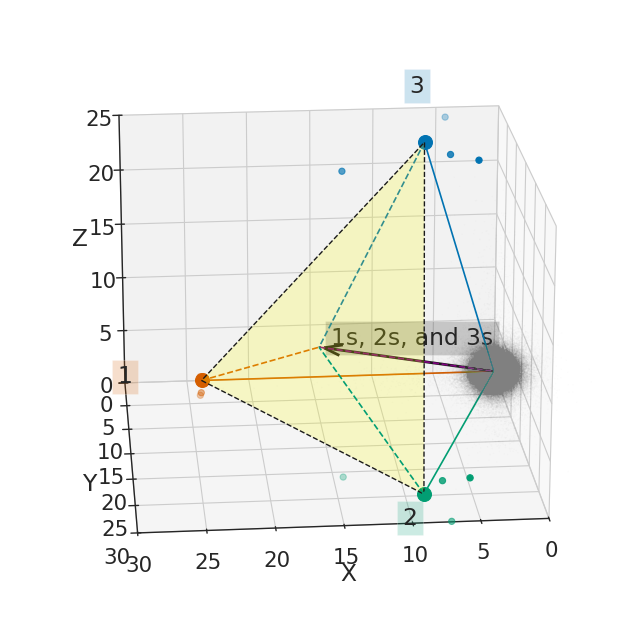

In [78]:
plot3(
    {'1': ['▁一', '1', "▁one", "▁One"], 
     '2': ['▁二', '2', "▁two", "▁Two"], 
     '3': ['▁三', '3', "▁three", "▁Three"],
    }, 
    '1s, 2s, and 3s'
)

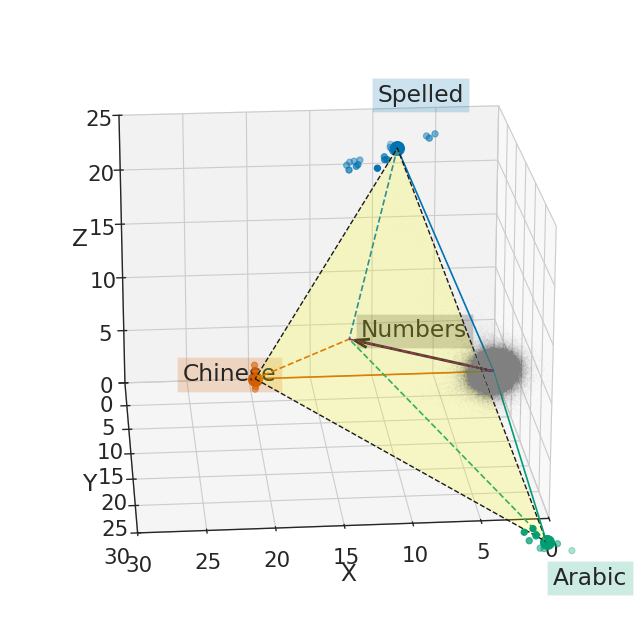

In [77]:
plot3(
    {'Chinese': ['▁一', '▁七', '▁三', '▁九', '▁二', '▁五', '▁八', '▁六', '▁十', '▁四'], 
     'Arabic': ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9'],
     'Spelled': make_token_set(["one", "two", "three", "four", "five", "six", "seven", "eight", "nine", "ten"]),
    }, 
    'Numbers'
)